<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x232F4076AD0>


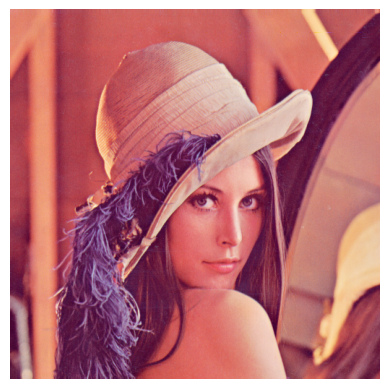

[[162 162 162 ... 170 155 128]
 [162 162 162 ... 170 155 128]
 [162 162 162 ... 170 155 128]
 ...
 [ 43  43  50 ... 104 100  98]
 [ 44  44  55 ... 104 105 108]
 [ 44  44  55 ... 104 105 108]]
(512, 512)
Image format: None
Image mode: L
Image size: (512, 512)


In [15]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Open an image file
image = Image.open("static\uploads\Baboon.jpg")

# Optionally, you can convert the image to grayscale
grayscale_image = image.convert("L")

# Now you can work with the image object, for example, display it
print(image)
plt.imshow(image, cmap='gray')  # Use 'gray' colormap for grayscale images
plt.axis('off')  # Turn off axis labels
plt.show()

# Convert the image to grayscale (optional)
image = image.convert('L')

# Get pixel values as a NumPy array
pixel_values = np.array(image)
P = np.vstack(pixel_values)

# Print the pixel values
print(P)
print(P.shape)


# To access image properties
print("Image format:", image.format)
print("Image mode:", image.mode)
print("Image size:", image.size)
M=image.size[0]
N = image.size[1]




In [16]:
import math
import numpy as np

def rotate_matrix_180(matrix):
    reversed_matrix = [row[::-1] for row in matrix[::-1]]
    return reversed_matrix
def pwlcg_iteration(x, p):
    if 0 <= x < p:
        return x/p
    elif p <= x < 0.5:
        return (x - p) / (0.5 - p)
    else:
        return pwlcg_iteration(1-x,p)


def generate_initial_values_and_parameters(secret_key):
    k1k8 = secret_key[:8]
    k9k16 = secret_key[8:16]


    # Step 1
    x00 = 0.8 * sum(int(ki, 16)/ (2**(4*i)) for i, ki in enumerate(k1k8, start=1)) + 0.1
    # print(x00)
    # Step 2
    p0 = 0.4 * sum((int(ki, 16)) / (2**(4*i)) for i, ki in enumerate(k9k16, start=1)) + 0.1
    # print(p0)

    return x00, p0

def main(secret_key):
    d = len(secret_key) // 16
    x00, p0 = generate_initial_values_and_parameters(secret_key)

    for i in range(64):
      x00 = pwlcg_iteration(x00, p0)


    if d > 1:
        for j in range(1, d):
            k1k8 = secret_key[16*j : 16*j +8]
            k9k16 = secret_key[16*j +8 : 16*j +16]

            # Step 6
            x0j = 0.8 * sum(int(ki, 16)/ (2**(4*i)) for i, ki in enumerate(k1k8, start=1)) + 0.1
            x0j = 0.382 * x0j +0.618*x00

            # Step 7
            pj = 0.4 * sum((int(ki, 16)) / (2**(4*i)) for i, ki in enumerate(k9k16, start=1)) + 0.1
            pj = 0.382 * pj + 0.618 * p0

            # Step 8
            for _ in range(64):
                x0j = pwlcg_iteration(x0j, pj)

            # Step 9
            x00 = x0j

#     print(f"Final x0: {x00}, Final p: {p0}")

    x0=pwlcg_iteration(x00, p0)
    Y = np.zeros((M, N))
    for i in range(M):
      for j in range(N):
        x0=pwlcg_iteration(x0, p0)
        Y[i][j]=x0
#     print(Y)
    X = np.zeros((M, N))
    for i in range(M):
      for j in range(N):
        X[i][j]=math.floor(Y[i][j]*(10**14))%256
#     print(X)

    # Z=rotate_matrix_180(X)
    # Z = np.vstack(Z)
    # print(Z)
    return X





secret_key = 'FEDCBA98765432100123456789ABCDEF02468ACE13579BDFF0E1D2C3B4A59687'
X=main(secret_key)
print(X)
Z=rotate_matrix_180(X)
Z = np.array(Z)
print(Z)

[[182.  77.  14. ... 218. 129. 133.]
 [206.  78. 181. ... 210. 119. 228.]
 [133. 254. 236. ... 187. 210.  84.]
 ...
 [ 24. 237. 190. ... 134. 150. 140.]
 [ 87. 163. 102. ... 211. 164.  16.]
 [143.  94. 158. ... 186. 118. 198.]]
[[198. 118. 186. ... 158.  94. 143.]
 [ 16. 164. 211. ... 102. 163.  87.]
 [140. 150. 134. ... 190. 237.  24.]
 ...
 [ 84. 210. 187. ... 236. 254. 133.]
 [228. 119. 210. ... 181.  78. 206.]
 [133. 129. 218. ...  14.  77. 182.]]


In [17]:
def forward_diffusion_algorithm(P, X):
    M = len(P)
    N = len(P[0])
    A = [[0] * N for _ in range(M)]

    i = 0
    j = 0
    A[i][j] = (P[i][j] + X[i][j]) % 256
    j += 1

    while j <= N - 1:
        A[i][j] = (P[i][j] + A[i][j - 1] + X[i][j]) % 256
        j += 1

    while j > N - 1:
        j = 0
        i += 1
        A[i][j] = (P[i][j] + A[i - 1][j] + A[i - 1][N - 1] + X[i][j]) % 256
        j += 1

        while j <= N - 1:
            A[i][j] = (P[i][j] + A[i - 1][j] + A[i][j - 1] + X[i][j]) % 256
            
            if i == M - 1 and j == N - 1:
                break
            j += 1

    return A
# def forward_diffusion_algorithm(P, X):
#     M = len(P)
#     N = len(P[0])
#     A = [[0] * N for _ in range(M)]

#     i = 1
#     j = 1
#     A[i-1][j-1] = (P[i-1][j-1] + X[i-1][j-1]) % 256
#     j += 1

#     while j < N :
#         A[i-1][j-1] = (P[i-1][j-1] + A[i-1][j - 2] + X[i-1][j-1]) % 256
#         j += 1

#     while i < M:
#         j = 1
#         i += 1
        
#         A[i-1][j-1] = (P[i-1][j-1] + A[i - 2][j-1] + A[i - 2][N-1] + X[i-1][j-1]) % 256
#         j += 1

#         while j <=N:
#             A[i-1][j-1] = (P[i-1][j-1] + A[i - 2][j-1] + A[i-1][j - 2] + X[i-1][j-1]) % 256
#             j += 1

#     return A


A = forward_diffusion_algorithm(P, X)
A=np.array(A)
print(A)

B = rotate_matrix_180(A)
B = np.array(B)
print(B)
# print(B.shape)


[[ 88.  71. 247. ...  11.  39.  44.]
 [244.  43. 121. ... 203.   4. 148.]
 [175. 122. 129. ... 228.  85. 189.]
 ...
 [222.  60. 147. ...  95. 183. 108.]
 [205. 216.   8. ... 141.  81.  57.]
 [193.  35.   0. ... 234.  26. 133.]]
[[133.  26. 234. ...   0.  35. 193.]
 [ 57.  81. 141. ...   8. 216. 205.]
 [108. 183.  95. ... 147.  60. 222.]
 ...
 [189.  85. 228. ... 129. 122. 175.]
 [148.   4. 203. ... 121.  43. 244.]
 [ 44.  39.  11. ... 247.  71.  88.]]


In [18]:
def plaintext_scrambling(B):
    M, N = B.shape
    D = np.copy(B)

    for i in range(M):
        for j in range(N):
            # Calculate the sums of the i-th row and j-th column
            Ri = np.sum(B[i, :]) - B[i, j]
            Hj = np.sum(B[:, j]) - B[i, j]

            # Calculate the new coordinates (m, n)
            if j % 2 == 0:
                m = (Hj % M)
                n = (Ri % N)
            else:
                m = M - (Hj % M)-1
                n = N - (Ri % N)-1
            m=int(m)
            n=int(n)
            # Check if the calculated m or n is equal to i or j
            if m== i and n == j:
                print("hello")
                # Swap B(i, j) and B(m, n)
                D[i, j], D[m, n] = D[m, n], D[i, j]

    return D
D = plaintext_scrambling(B)

print("\nMatrix D:")
print(D)
D=np.array(D)
E=rotate_matrix_180(D)
E=np.array(E)
print(E)
# f = [[1,2,3,20],[4,5,6,12],[7,8,9,77]]
# # f = f.tolist()
# f=np.array(f)
# f = plaintext_scrambling(f)
# f = rotate_matrix_180(f)
# f=np.array(f)
# print(f)

# g = [[1,2,3,20],[4,5,6,12],[7,8,9,77]]
# g=np.array(g)
# g=rotate_matrix_180(g)
# g=np.array(g)
# g= plaintext_scrambling(g)
# print(g)


hello

Matrix D:
[[133.  26. 234. ...   0.  35. 193.]
 [ 57.  81. 141. ...   8. 216. 205.]
 [108. 183.  95. ... 147.  60. 222.]
 ...
 [189.  85. 228. ... 129. 122. 175.]
 [148.   4. 203. ... 121.  43. 244.]
 [ 44.  39.  11. ... 247.  71.  88.]]
[[ 88.  71. 247. ...  11.  39.  44.]
 [244.  43. 121. ... 203.   4. 148.]
 [175. 122. 129. ... 228.  85. 189.]
 ...
 [222.  60. 147. ...  95. 183. 108.]
 [205. 216.   8. ... 141.  81.  57.]
 [193.  35.   0. ... 234.  26. 133.]]


In [19]:
# def backward_diffusion_algorithm(E, Z):
#     M = len(E)
#     N = len(E[0])  # Assuming all rows have the same length

#     F = [[0] * N for _ in range(M)]
#     i, j = 0, 0  # Start indices from 0, 0

#     while i < M:
#         while j < N:
#             if j == N - 1:
#                 F[i][j] = (256 * 3 + E[i][j] - E[(i + 1) % M][N - 1] - E[(i + 1) % M][0] - Z[i][j]) % 256
#             else:
#                 F[i][j] = (256 * 3 + E[i][j] - E[i][j + 1] - E[(i + 1) % M][j] - Z[i][j]) % 256
#             j += 1

#         j = 0
#         i += 1

#         if i == M:
#             break

#     i, j = M - 1, 0  # Reset indices for the second phase

#     while j < N:
#         if j == N - 1:
#             F[i][j] = (256 + E[i][j] - Z[i][j]) % 256
#         else:
#             F[i][j] = (256 * 2 + E[i][j] - E[M - 1][(j + 1) % N] - Z[i][j]) % 256
#         j += 1

#     return F

def backward_diffusion_algorithm(E, Z):
    M = len(E)
    N = len(E[0]) 
    F = [[0] * N for _ in range(M)]
    i, j = 0, 0  # Start indices from 0, 0

    while i < M:
        while j < N:
            if j == N - 1:
                F[i][j] = (256 * 3 + E[i][j] - E[(i + 1) % M][N - 1] - E[(i + 1) % M][0] - Z[i][j]) % 256
            else:
                F[i][j] = (256 * 3 + E[i][j] - E[i][j + 1] - E[(i + 1) % M][j] - Z[i][j]) % 256
            j += 1

        j = 0
        i += 1

     

        if i == M - 1:
            while j < N:
                if j == N - 1:
                    F[i][j] = (256 + E[i][j] - Z[i][j]) % 256
                else:
                    F[i][j] = (256 * 2 + E[i][j] - E[M - 1][(j + 1) % N] - Z[i][j]) % 256
                j += 1

    return F

F=backward_diffusion_algorithm(E, Z)
# print(F)
# F=np.array(F)
# print(F.shape)
F=np.array(F).reshape(M,N)
print(F)
print(F.shape)
C=rotate_matrix_180(F)
C=np.array(C).reshape(M,N)

print(C)

[[ 87. 175. 254. ... 123. 153.  21.]
 [ 10. 148. 143. ... 125. 120. 209.]
 [245. 185. 220. ... 139. 240. 133.]
 ...
 [129. 255. 110. ...  47. 252. 225.]
 [ 80.  54.  26. ... 157. 176.  37.]
 [ 25. 162.  37. ... 194.  72. 207.]]
(512, 512)
[[207.  72. 194. ...  37. 162.  25.]
 [ 37. 176. 157. ...  26.  54.  80.]
 [225. 252.  47. ... 110. 255. 129.]
 ...
 [133. 240. 139. ... 220. 185. 245.]
 [209. 120. 125. ... 143. 148.  10.]
 [ 21. 153. 123. ... 254. 175.  87.]]


[[236. 179. 242. ...  37. 112.  96.]
 [178.  16. 169. ... 131. 223. 129.]
 [251.  96. 114. ... 154. 132.  17.]
 ...
 [133. 229.  23. ...  24.   4.  18.]
 [ 72.  50. 115. ... 201. 249. 145.]
 [  5. 118.  54. ... 226.  34. 209.]]


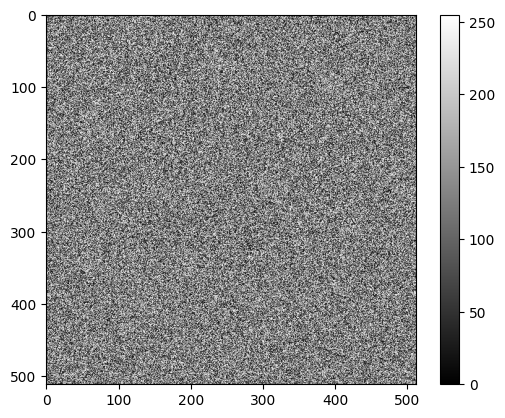

In [21]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(C, cmap='gray') 
plt.colorbar() 
plt.show()


In [22]:
A_d=forward_diffusion_algorithm(C, X)
# print(A_d)
A_d=np.array(A_d)
print(A_d)
print(A_d.shape)
for i in range(M):
    for j in range(N):
        if D[i][j]!=A_d[i][j]:
            print("No")


B_d=rotate_matrix_180(A_d)
B_d=np.array(B_d)
print(B_d)
print(B_d.shape)

[[133.  26. 234. ...   0.  35. 193.]
 [ 57.  81. 141. ...   8. 216. 205.]
 [108. 183.  95. ... 147.  60. 222.]
 ...
 [189.  85. 228. ... 129. 122. 175.]
 [148.   4. 203. ... 121.  43. 244.]
 [ 44.  39.  11. ... 247.  71.  88.]]
(512, 512)
[[ 88.  71. 247. ...  11.  39.  44.]
 [244.  43. 121. ... 203.   4. 148.]
 [175. 122. 129. ... 228.  85. 189.]
 ...
 [222.  60. 147. ...  95. 183. 108.]
 [205. 216.   8. ... 141.  81.  57.]
 [193.  35.   0. ... 234.  26. 133.]]
(512, 512)


In [23]:
D_d=plaintext_scrambling(B_d)
D_d=np.array(D_d)
print(D_d)
# print(D_d.shape)
E_d=rotate_matrix_180(D_d)
E_d=np.array(E_d)
print(E_d)
print(E_d.shape)


hello
[[ 88.  71. 247. ...  11.  39.  44.]
 [244.  43. 121. ... 203.   4. 148.]
 [175. 122. 129. ... 228.  85. 189.]
 ...
 [222.  60. 147. ...  95. 183. 108.]
 [205. 216.   8. ... 141.  81.  57.]
 [193.  35.   0. ... 234.  26. 133.]]
[[133.  26. 234. ...   0.  35. 193.]
 [ 57.  81. 141. ...   8. 216. 205.]
 [108. 183.  95. ... 147.  60. 222.]
 ...
 [189.  85. 228. ... 129. 122. 175.]
 [148.   4. 203. ... 121.  43. 244.]
 [ 44.  39.  11. ... 247.  71.  88.]]
(512, 512)


In [24]:
F_d=backward_diffusion_algorithm(E_d, Z)
F_d=np.array(F_d).reshape(M,N)
print(F_d)
print(F_d.shape)
P_dec=rotate_matrix_180(F_d)
P_dec=np.array(P_dec)
print(P_dec)
print(P_dec.shape)


[[108. 105. 104. ...  55.  44.  44.]
 [108. 105. 104. ...  55.  44.  44.]
 [ 98. 100. 104. ...  50.  43.  43.]
 ...
 [128. 155. 170. ... 162. 162. 162.]
 [128. 155. 170. ... 162. 162. 162.]
 [128. 155. 170. ... 162. 162. 162.]]
(512, 512)
[[162. 162. 162. ... 170. 155. 128.]
 [162. 162. 162. ... 170. 155. 128.]
 [162. 162. 162. ... 170. 155. 128.]
 ...
 [ 43.  43.  50. ... 104. 100.  98.]
 [ 44.  44.  55. ... 104. 105. 108.]
 [ 44.  44.  55. ... 104. 105. 108.]]
(512, 512)


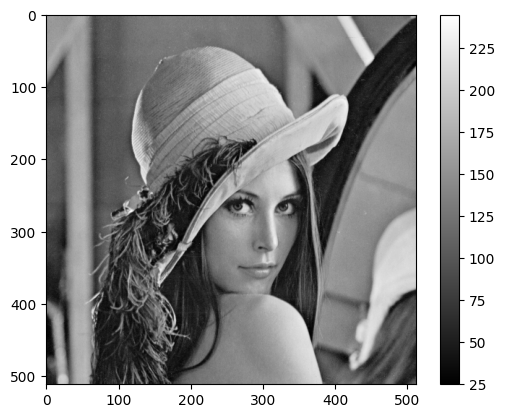

In [25]:
plt.imshow(P_dec, cmap='gray')  
plt.colorbar()  
plt.show()